In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision

#Download dataset and divide it into train and test set

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

In [4]:
batch_size =32

In [5]:
import torchvision

In [6]:
cdata=torchvision.datasets.EMNIST(root='emnist',split='balanced',download=True)

##Size and shpae of images 

In [50]:
print(cdata.classes)
print(str(len(cdata.classes))+'classes')



print('\nData size:')
print(cdata.data.shape)

images=cdata.data.view([112800,1,28,28]).float()
print('\nTensor data:')
print(images.shape)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
47classes

Data size:
torch.Size([112800, 28, 28])

Tensor data:
torch.Size([112800, 1, 28, 28])


## another method for Loading dataset

In [8]:
# Define the transform to convert the images to PyTorch tensors and normalize the pixel values 
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))]) 

# Load the training and test datasets 
trainset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=True, 
                                        download=True, transform=transform) 
testset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=False, 
                                       download=True, transform=transform) 
trainset, val_dataset = torch.utils.data.random_split(
    trainset, (94000, 18800)
)

# Define the data loaders to load the data in batches 
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, 
                                          shuffle=True, num_workers=2) 
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, 
                                         shuffle=True, num_workers=2)
test_dataset = torchvision.datasets.EMNIST(
    root="./data",split='balanced', train=False, download=True, transform=transforms.ToTensor()
)

val_loader =  torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)


In [9]:
print(f"{len(train_loader.dataset)}")
print(f"{len(val_loader.dataset)}")
print(f"{len(test_loader.dataset)}")

94000
18800
18800


#models Introduction 

In [10]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size: int, n_classes: int) -> None:
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 47)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
input_size = 28 * 28
num_classes = len(test_dataset.classes)
learning_rate = 0.001
EPOCHS = 20

In [12]:
len(test_dataset.classes)

47

In [13]:
model = SimpleMLP(input_size, num_classes).to(device)

##Define loss function and optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

##Train model

## Functions

In [15]:
def validation(
    model: torch.nn.modules.module,
    val_loader: torch.utils.data.dataloader,
    loss_fn: torch.nn.modules.loss,
) -> float:
    """
    compute validation loss with corresponding model and loss function
    return validation loss
    """

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc="Validation"):
            data = data.to(device)
            targets = targets.to(device)

            data = data.reshape(data.shape[0], -1)

            scores = model(data)

            loss = loss_fn(scores, targets)
            total_loss += loss.item()

    return total_loss / len(val_loader)

In [16]:
def training(
    model: torch.nn.modules.module,
    train_dataset: torch.utils.data.dataloader,
    val_dataset: torch.utils.data.dataloader,
    criterion: torch.nn.modules.loss,
    optimizer: torch.optim,
    epochs: int = 5,
) -> tuple:

    """
    train model with given train set and optimizer
    return train and validation losses
    """
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):
        for data, targets in tqdm(train_dataset, desc=f"Epoch {epoch + 1}"):
            # convert data and target to device
            data = data.to(device)
            targets = targets.to(device)
            # flatten data to shape 28* 28
            data = data.reshape(data.shape[0], -1)

            # forward pass
            scores = model(data)
            loss = criterion(scores, targets)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()

        # validation
        val_loss = validation(model, val_dataset, criterion)
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        print(f"Train Loss: {np.mean(train_losses):.2f}, ", end="")
        print(f"Validation Loss: {np.mean(val_losses):.2f}")

    return train_losses, val_losses

In [17]:
def inference(
    model: torch.nn.modules.module, test_dataset: torch.utils.data.dataloader
) -> float:

    """
    inference model on test set
    return test accuracy
    """

    n_samples = 0
    n_correct = 0
    model.eval()

    with torch.no_grad():
        for data, targets in tqdm(test_dataset):
            data = data.to(device)
            targets = targets.to(device)

            data = data.reshape(data.shape[0], -1)

            scores = model(data)
            _, preds = scores.max(1)
            n_correct += (preds == targets).sum().item()
            n_samples += targets.size(0)

        return n_correct / n_samples

In [18]:
def print_acc(acc: float, train: bool = True) -> None:
    """
    print accuracy in appropriate format
    """
    if train:
        print(f"Train Accuracy: {acc * 100:.2f}%")
    else:
        print(f"Test Accuracy: {acc * 100:.2f}%")

In [19]:
def plot(train_loss: list, val_loss: list) -> None:
    """
    plotting train and validation losses
    """
    epochs = list(range(1, len(train_loss) + 1))

    plt.plot(epochs, train_loss, label="train loss")
    plt.plot(epochs, val_loss, label="validation loss")
    plt.xlabel("# epochs")
    plt.xticks(epochs)
    plt.ylabel("loss")
    plt.legend()
    # fig, ax = plt.subplots(1,2,figsize =(12,5))

    # ax[0].plot(epochs,train_loss)
    # ax[0].set_title('training loss')
    # ax[0].set(xlabel = '# epochs', ylabel = 'loss' )

    # ax[1].plot(epochs,val_loss)
    # ax[1].set_title('validation loss')
    # ax[1].set(xlabel = '# epochs', ylabel = 'loss' )

    plt.show()

In [20]:
train_losses, val_losses = training(
    model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.81, Validation Loss: 1.18


Epoch 2:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.85, Validation Loss: 1.10


Epoch 3:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.87, Validation Loss: 1.04


Epoch 4:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 1.04, Validation Loss: 1.00


Epoch 5:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.99, Validation Loss: 0.97


Epoch 6:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.88, Validation Loss: 0.95


Epoch 7:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.83, Validation Loss: 0.93


Epoch 8:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.89, Validation Loss: 0.92


Epoch 9:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.83, Validation Loss: 0.91


Epoch 10:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.80, Validation Loss: 0.90


Epoch 11:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.78, Validation Loss: 0.89


Epoch 12:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.81, Validation Loss: 0.88


Epoch 13:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.86, Validation Loss: 0.87


Epoch 14:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.83, Validation Loss: 0.86


Epoch 15:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.81, Validation Loss: 0.86


Epoch 16:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.80, Validation Loss: 0.85


Epoch 17:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.79, Validation Loss: 0.85


Epoch 18:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.77, Validation Loss: 0.85


Epoch 19:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.80, Validation Loss: 0.84


Epoch 20:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.78, Validation Loss: 0.84


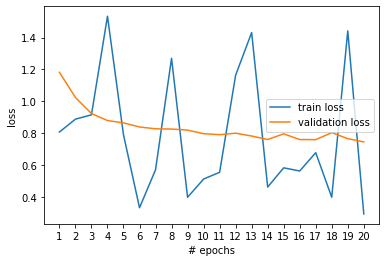

In [21]:
plot(train_losses, val_losses)

In [22]:
train_acc = inference(model, train_loader)
print_acc(train_acc)

  0%|          | 0/2938 [00:00<?, ?it/s]

Train Accuracy: 78.80%


In [23]:
test_acc = inference(model, test_loader)
print_acc(test_acc, train=False)

  0%|          | 0/588 [00:00<?, ?it/s]

Test Accuracy: 76.62%


##  Model 2

In [24]:
class BigMLP(nn.Module):
    def __init__(self, input_size: int, n_classes: int) -> None:
        super(BigMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64,47)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
big_mlp = BigMLP(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(big_mlp.parameters(), lr=learning_rate)

In [26]:
train_losses, val_losses = training(
    big_mlp, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.69, Validation Loss: 0.97


Epoch 2:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.87, Validation Loss: 0.92


Epoch 3:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.89, Validation Loss: 0.88


Epoch 4:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.89, Validation Loss: 0.85


Epoch 5:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.87, Validation Loss: 0.82


Epoch 6:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.77, Validation Loss: 0.80


Epoch 7:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.70, Validation Loss: 0.78


Epoch 8:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.66, Validation Loss: 0.78


Epoch 9:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.64, Validation Loss: 0.77


Epoch 10:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.64, Validation Loss: 0.76


Epoch 11:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.63, Validation Loss: 0.75


Epoch 12:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.63, Validation Loss: 0.75


Epoch 13:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.67, Validation Loss: 0.74


Epoch 14:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.66, Validation Loss: 0.73


Epoch 15:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.64, Validation Loss: 0.73


Epoch 16:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.73


Epoch 17:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.64, Validation Loss: 0.72


Epoch 18:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.64, Validation Loss: 0.72


Epoch 19:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.62, Validation Loss: 0.71


Epoch 20:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.62, Validation Loss: 0.71


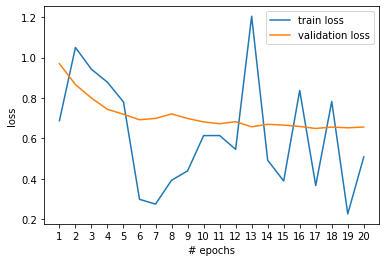

In [27]:
plot(train_losses, val_losses)

In [28]:
train_acc = inference(big_mlp, train_loader)
print_acc(train_acc)

  0%|          | 0/2938 [00:00<?, ?it/s]

Train Accuracy: 81.69%


In [29]:
test_acc = inference(big_mlp, test_loader)
print_acc(test_acc, train=False)

  0%|          | 0/588 [00:00<?, ?it/s]

Test Accuracy: 78.76%


##Model 3

In [30]:
class BiggerMLP(nn.Module):
    def __init__(self, input_size: int, n_classes: int) -> None:
        super(BiggerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 47)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [31]:
bigger_mlp = BiggerMLP(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bigger_mlp.parameters(), lr=learning_rate)

In [32]:
train_losses, val_losses = training(
    bigger_mlp, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.63, Validation Loss: 0.91


Epoch 2:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.80, Validation Loss: 0.84


Epoch 3:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.72, Validation Loss: 0.80


Epoch 4:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.68, Validation Loss: 0.78


Epoch 5:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.76


Epoch 6:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.75


Epoch 7:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.59, Validation Loss: 0.73


Epoch 8:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.66, Validation Loss: 0.72


Epoch 9:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.64, Validation Loss: 0.72


Epoch 10:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.71


Epoch 11:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.63, Validation Loss: 0.71


Epoch 12:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.71


Epoch 13:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.70


Epoch 14:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.64, Validation Loss: 0.70


Epoch 15:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.70


Epoch 16:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.70


Epoch 17:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.64, Validation Loss: 0.69


Epoch 18:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.62, Validation Loss: 0.69


Epoch 19:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.62, Validation Loss: 0.69


Epoch 20:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.61, Validation Loss: 0.69


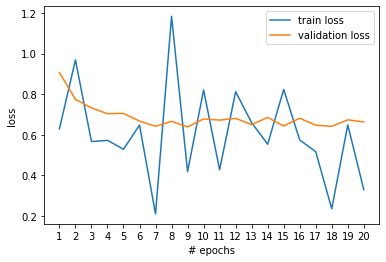

In [33]:
plot(train_losses, val_losses)

In [34]:
train_acc = inference(bigger_mlp, train_loader)
print_acc(train_acc)

  0%|          | 0/2938 [00:00<?, ?it/s]

Train Accuracy: 82.95%


In [35]:
test_acc = inference(bigger_mlp, test_loader)
print_acc(test_acc, train=False)

  0%|          | 0/588 [00:00<?, ?it/s]

Test Accuracy: 78.77%


#dropout technique

In [36]:
class MLP_Dropout(nn.Module):
    def __init__(self, input_size: int, n_classes: int) -> None:
        super(MLP_Dropout, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 47)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [37]:
dropout_model = MLP_Dropout(input_size, num_classes).to(device)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dropout_model.parameters(), lr=learning_rate)

In [39]:
train_losses, val_losses = training(
    dropout_model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 2.10, Validation Loss: 1.64


Epoch 2:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 1.56, Validation Loss: 1.30


Epoch 3:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 1.15, Validation Loss: 1.15


Epoch 4:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 1.12, Validation Loss: 1.08


Epoch 5:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.99, Validation Loss: 1.02


Epoch 6:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.96, Validation Loss: 0.98


Epoch 7:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.91, Validation Loss: 0.94


Epoch 8:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.85, Validation Loss: 0.92


Epoch 9:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.82, Validation Loss: 0.90


Epoch 10:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.85, Validation Loss: 0.89


Epoch 11:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.88, Validation Loss: 0.87


Epoch 12:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.88, Validation Loss: 0.86


Epoch 13:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.83, Validation Loss: 0.85


Epoch 14:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.78, Validation Loss: 0.84


Epoch 15:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.77, Validation Loss: 0.83


Epoch 16:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.76, Validation Loss: 0.83


Epoch 17:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.74, Validation Loss: 0.82


Epoch 18:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.74, Validation Loss: 0.82


Epoch 19:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.74, Validation Loss: 0.81


Epoch 20:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.72, Validation Loss: 0.81


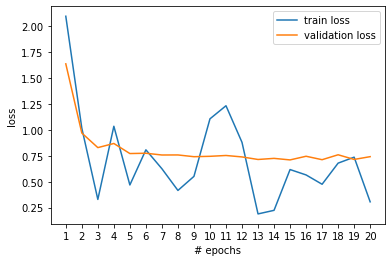

In [40]:
plot(train_losses, val_losses)

In [41]:
train_acc = inference(dropout_model, train_loader)
print_acc(train_acc)

  0%|          | 0/2938 [00:00<?, ?it/s]

Train Accuracy: 80.20%


In [42]:
test_acc = inference(dropout_model, test_loader)
print_acc(test_acc)

  0%|          | 0/588 [00:00<?, ?it/s]

Train Accuracy: 77.12%


# batch normalization 

In [43]:
class MLP_BatchNorm(nn.Module):
    def __init__(self, input_size: int, n_classes: int) -> None:
        super(MLP_BatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128,47)
        self.bn_1 = nn.BatchNorm1d(32)
        self.bn_2 = nn.BatchNorm1d(64)
        self.bn_3 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn_1(x)
        x = F.relu(self.fc2(x))
        x = self.bn_2(x)
        x = F.relu(self.fc3(x))
        x = self.bn_3(x)
        x = self.fc4(x)
        return x

In [44]:
batchnorm_model = MLP_BatchNorm(input_size, num_classes).to(device)

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(batchnorm_model.parameters(), lr=learning_rate)

In [46]:
train_losses, val_losses = training(
    batchnorm_model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 1.16, Validation Loss: 0.79


Epoch 2:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.72, Validation Loss: 0.73


Epoch 3:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.71, Validation Loss: 0.71


Epoch 4:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.72, Validation Loss: 0.70


Epoch 5:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.69


Epoch 6:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.69, Validation Loss: 0.68


Epoch 7:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.65, Validation Loss: 0.67


Epoch 8:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.62, Validation Loss: 0.66


Epoch 9:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.58, Validation Loss: 0.65


Epoch 10:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.61, Validation Loss: 0.65


Epoch 11:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.58, Validation Loss: 0.65


Epoch 12:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.56, Validation Loss: 0.64


Epoch 13:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.56, Validation Loss: 0.64


Epoch 14:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.54, Validation Loss: 0.63


Epoch 15:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.56, Validation Loss: 0.63


Epoch 16:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.57, Validation Loss: 0.63


Epoch 17:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.58, Validation Loss: 0.63


Epoch 18:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.60, Validation Loss: 0.62


Epoch 19:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.61, Validation Loss: 0.62


Epoch 20:   0%|          | 0/2938 [00:00<?, ?it/s]

Validation:   0%|          | 0/588 [00:00<?, ?it/s]

Train Loss: 0.60, Validation Loss: 0.62


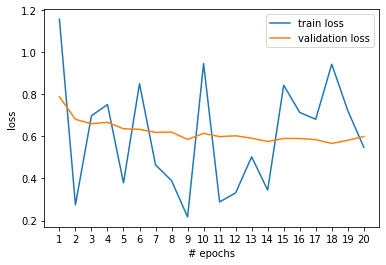

In [47]:
plot(train_losses, val_losses)

In [48]:
train_acc = inference(batchnorm_model, train_loader)
print_acc(train_acc)

  0%|          | 0/2938 [00:00<?, ?it/s]

Train Accuracy: 84.66%


In [49]:
test_acc = inference(batchnorm_model, test_loader)
print_acc(test_acc)

  0%|          | 0/588 [00:00<?, ?it/s]

Train Accuracy: 80.52%
